In [2]:
!pip install pandas yfinance

In [64]:
!pip install seaborn matplotlib


In [38]:
import yfinance as yf
import pandas as pd
import datetime as dt
import os

In [44]:


# Define function to fetch scalping data
def scalping_data(ticker, lookback_days=5):
    interval = '1m'
    end_date = dt.datetime.now()

    # Calculate the start date based on lookback_days
    start_date = end_date - pd.Timedelta(days=lookback_days)

    # Initialize an empty DataFrame to store results
    all_data = pd.DataFrame()

    # Fetch data in chunks of up to 6 days
    while start_date < end_date:
        chunk_end_date = min(start_date + pd.Timedelta(days=6), end_date)
        try:
            # Fetch data for the chunk period
            data = yf.download(ticker, start=start_date, end=chunk_end_date, interval=interval)
            data = data.reset_index()  # Reset index to have 'Datetime' as a column
            all_data = pd.concat([all_data, data], ignore_index=True)  # Append data
        except Exception as e:
            print(f"Error fetching data for {ticker} from {start_date} to {chunk_end_date}: {e}")

        # Move to the next chunk
        start_date = chunk_end_date
        # Set 'Datetime' column as index and convert to DatetimeIndex
        all_data = all_data.set_index('Datetime')
        all_data.index = pd.to_datetime(all_data.index)
        print(all_data.index.tzinfo)

    return all_data





In [45]:
# Function to save data to Parquet
def save_to_parquet(data, ticker, filename):
    if not data.empty:
        # Ensure the 'Datetime' column is set as the index for efficient deduplication
        if 'Datetime' not in data.index.names:
            data = data.set_index('Datetime')

        # Create the folder if it doesn't exist
        os.makedirs(os.path.dirname(filename), exist_ok=True)

        # Save or append data to a Parquet file
        if os.path.exists(filename):
            # Load existing data
            existing_data = pd.read_parquet(filename)

            # Ensure the 'Datetime' column is set as the index for the existing data as well
            if 'Datetime' not in existing_data.index.names:
                existing_data = existing_data.set_index('Datetime')

            # Combine new data with existing data and remove duplicates based on the index
            combined_data = pd.concat([existing_data, data]).loc[~pd.concat([existing_data, data]).index.duplicated(keep='last')]

            # Save combined data to Parquet
            combined_data.to_parquet(filename)
        else:
            # Save new data to a Parquet file
            data.to_parquet(filename)

        print(f"Data saved to {filename}.")
    else:
        print("No new data to save.")



In [51]:
# Main function to run daily and update the Parquet database
def update_scalping_database(ticker, database_path='scalping_data.parquet'):
    # Load existing data to determine the last date available
    if os.path.exists(database_path):
        existing_data = pd.read_parquet(database_path)

        # Check if 'Datetime' column exists. If not, try 'Date'
        if 'Datetime' in existing_data.columns:
            last_date = existing_data['Datetime'].max()
        elif 'Date' in existing_data.columns:
            last_date = existing_data['Date'].max()
        else:
            # Handle case where neither column exists
            print("Error: No 'Datetime' or 'Date' column found in the Parquet file.")
            return

        # Calculate days since the last update
        days_since_last_update = (pd.Timestamp.now(tz='UTC').to_pydatetime() - last_date.to_pydatetime()).days # Make both datetime objects timezone aware and convert to python datetime objects
    else:
        days_since_last_update = 5  # Default to fetching the last 5 days if no data exists

    # Fetch new data and update the database
    new_data = scalping_data(ticker, lookback_days=days_since_last_update)
    save_to_parquet(new_data, ticker, database_path)

In [52]:
# Function to read data from a Parquet file
def read_parquet_data(filename):
    try:
        # Read data from the Parquet file
        data = pd.read_parquet(filename)
        print(f"Data loaded successfully from {filename}.")
        return data
    except Exception as e:
        print(f"Error reading data from {filename}: {e}")
        return pd.DataFrame()  # Return an empty DataFrame if reading fails



In [53]:
ticker = 'GC=F'
data = scalping_data(ticker)

[*********************100%***********************]  1 of 1 completed

America/New_York


In [54]:
save_to_parquet(data, ticker, f'data/{ticker}L_scalping_data.parquet')

Data saved to data/GC=FL_scalping_data.parquet.


In [55]:
# Example usage
update_scalping_database(f'{ticker}', f'data/{ticker}_scalping_data.parquet')

Error: No 'Datetime' or 'Date' column found in the Parquet file.


In [56]:
# Example usage
ticker_2 = 'BTC-USD'
database_path = f'data/{ticker}_scalping_data.parquet'
data = read_parquet_data(database_path)

# Display basic info about the loaded data
if not data.empty:
    print(data.head())  # Show the first 5 rows
    print("\nData Summary:")
    print(data.describe())  # Provide a statistical summary
    print("\nData Info:")
    print(data.info())  # Show column names and data types
    print("\nData Shape:")
    print(data.shape)  # Show the number of rows and columns
    print("\nData Columns:")
    print(data.columns)  # Show column names
    print("\nData Types:")
    print(data.dtypes)  # Show data types of each column
    print("\nNAN Values:")
    print(data.isnull().sum())

else:
    print("No data available.")


Data loaded successfully from data/GC=F_scalping_data.parquet.
                                  Open         High          Low        Close  \
Datetime                                                                        
2024-09-03 02:04:00-04:00  2524.899902  2525.399902  2524.800049  2525.199951   
2024-09-03 02:05:00-04:00  2525.300049  2525.399902  2525.100098  2525.100098   
2024-09-03 02:06:00-04:00  2525.199951  2526.600098  2525.199951  2526.300049   
2024-09-03 02:07:00-04:00  2526.300049  2526.699951  2526.100098  2526.500000   
2024-09-03 02:08:00-04:00  2526.600098  2527.199951  2526.500000  2527.000000   

                             Adj Close  Volume  
Datetime                                        
2024-09-03 02:04:00-04:00  2525.199951       0  
2024-09-03 02:05:00-04:00  2525.100098      31  
2024-09-03 02:06:00-04:00  2526.300049     172  
2024-09-03 02:07:00-04:00  2526.500000     260  
2024-09-03 02:08:00-04:00  2527.000000     195  

Data Summary:
           

In [57]:
check = (data['Volume'] < 0)

In [58]:
check.isna().sum()

0

In [59]:
volume = ( data.loc[data['Volume'] >  data['Volume'].mean()] )

In [60]:
volume

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2024-09-03 02:06:00-04:00,2525.199951,2526.600098,2525.199951,2526.300049,2526.300049,172
2024-09-03 02:07:00-04:00,2526.300049,2526.699951,2526.100098,2526.500000,2526.500000,260
2024-09-03 02:08:00-04:00,2526.600098,2527.199951,2526.500000,2527.000000,2527.000000,195
2024-09-03 02:09:00-04:00,2527.100098,2527.500000,2526.800049,2527.100098,2527.100098,456
2024-09-03 02:10:00-04:00,2527.100098,2527.500000,2526.300049,2526.600098,2526.600098,468
...,...,...,...,...,...,...
2024-09-06 15:31:00-04:00,2525.199951,2525.800049,2524.899902,2525.800049,2525.800049,165
2024-09-06 15:48:00-04:00,2525.699951,2526.300049,2525.300049,2526.300049,2526.300049,154
2024-09-06 15:52:00-04:00,2525.199951,2525.699951,2525.000000,2525.399902,2525.399902,191


In [62]:
# Assuming 'data' is your DataFrame with a 'Datetime' index
# Ensure the 'Datetime' index is in datetime format
data['Datetime'] = pd.to_datetime(data.index)

# Define a function to categorize the market session
def market_session(time):
    if time.time() < pd.Timestamp("03:00").time() and time.time() < pd.Timestamp("04:00").time():
        return "Asian + London"
    elif time.time() >= pd.Timestamp("04:00").time() and time.time() < pd.Timestamp("08:00").time():
        return "London"
    elif time.time() >= pd.Timestamp("08:00").time() and time.time() < pd.Timestamp("10:30").time():
        return "NYC + London"
    elif time.time() >= pd.Timestamp("10:30").time() and time.time() < pd.Timestamp("14:00").time():
        return "NYC"
    elif time.time() >= pd.Timestamp("14:00").time() and time.time() <= pd.Timestamp("16:00").time():
        return "NYC Close"
    elif time.time() > pd.Timestamp("16:00").time() and time.time() <= pd.Timestamp("22:00").time():
        return "Asian 4H"
    elif time.time() > pd.Timestamp("22:00").time() and time.time() <= pd.Timestamp("3:00").time():
        return "Asian"
    else:
        return "Other"




In [63]:
# Apply the function to create a new column
data['Market_Session'] = data['Datetime'].apply(market_session)

# Filter the data where volume is greater than the mean volume
mean_volume = data['Volume'].mean()
high_volume_data = data.loc[data['Volume'] > mean_volume]

# Group by 'Market_Session' to see the count of high-volume periods by session
session_counts = high_volume_data['Market_Session'].value_counts()

print(session_counts)


Market_Session
NYC + London      461
NYC               416
London            250
Asian + London     77
Other              53
NYC Close          47
Asian 4H           18
Name: count, dtype: int64


In [32]:
print(data.index.tzinfo)

America/New_York


<ipython-input-65-6bb0f564e825>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Market_Session', y='Count', data=session_counts_df, palette='viridis')


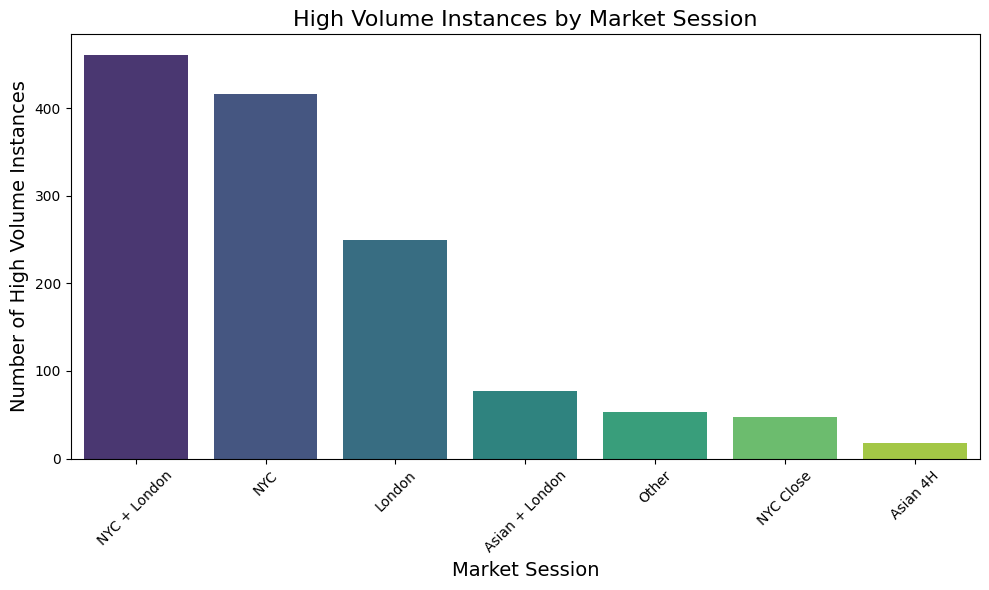

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare the data for plotting
session_counts_df = session_counts.reset_index()  # Convert the Series to a DataFrame
session_counts_df.columns = ['Market_Session', 'Count']  # Rename columns for clarity

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Plot the bar chart using seaborn
sns.barplot(x='Market_Session', y='Count', data=session_counts_df, palette='viridis')

# Customize the plot
plt.title('High Volume Instances by Market Session', fontsize=16)
plt.xlabel('Market Session', fontsize=14)
plt.ylabel('Number of High Volume Instances', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()  # Adjust layout for better fit
plt.show()


<ipython-input-77-74708bdd57e5>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Market_Session', y='Count', data=session_data, palette='viridis')


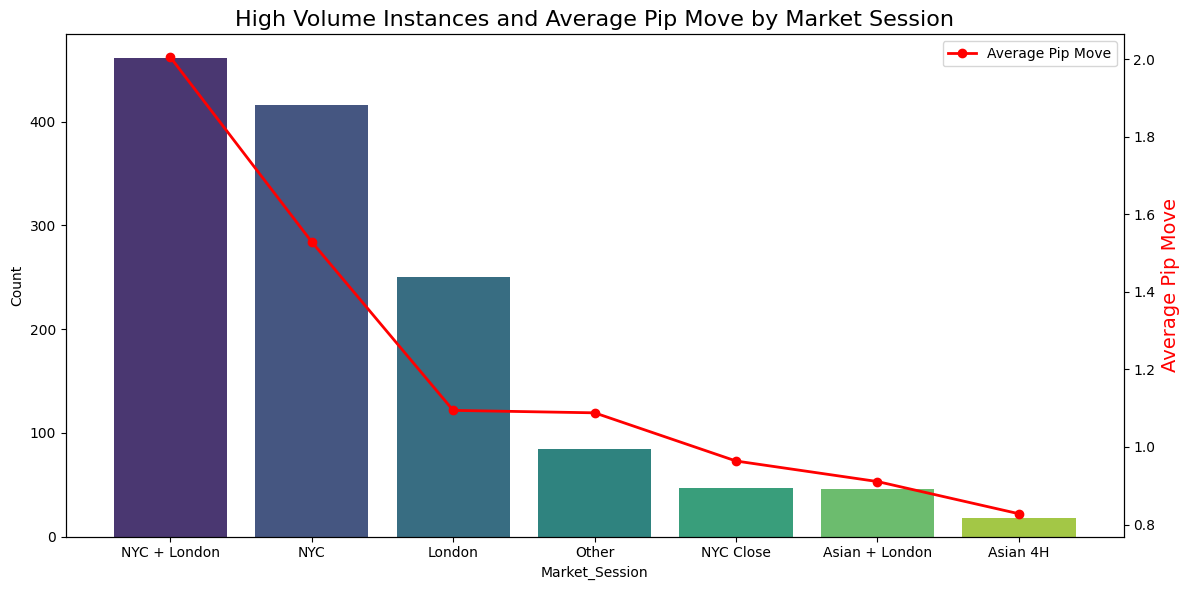

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the average close price, pip range, and other metrics
average_close_by_session = high_volume_data.groupby('Market_Session')['Close'].mean()
average_low_by_session = high_volume_data.groupby('Market_Session')['Low'].mean()
average_high_by_session = high_volume_data.groupby('Market_Session')['High'].mean()
average_pip_by_session = average_high_by_session - average_low_by_session

# Merge the session counts and average metrics into one DataFrame
session_data = session_counts.reset_index()
session_data.columns = ['Market_Session', 'Count']  # Rename columns for clarity
session_data['Average_Pip'] = session_data['Market_Session'].map(average_pip_by_session)
session_data['Average_Close'] = session_data['Market_Session'].map(average_close_by_session)

# Set up the matplotlib figure
plt.figure(figsize=(12, 6))

# Plot the bar chart for high-volume counts using seaborn
sns.barplot(x='Market_Session', y='Count', data=session_data, palette='viridis')

# Plot the line chart for average pip move using matplotlib
plt.twinx()  # Create a second y-axis
plt.plot(session_data['Market_Session'], session_data['Average_Pip'], color='red', marker='o', linestyle='-', linewidth=2, label='Average Pip Move')

# Customize the plot
plt.title('High Volume Instances and Average Pip Move by Market Session', fontsize=16)
plt.xlabel('Market Session', fontsize=14)
plt.ylabel('Number of High Volume Instances', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Set label for the second y-axis
plt.ylabel('Average Pip Move', fontsize=14, color='red')

# Add legend for the line chart
plt.legend(loc='upper right')

# Show the plot
plt.tight_layout()  # Adjust layout for better fit
plt.show()


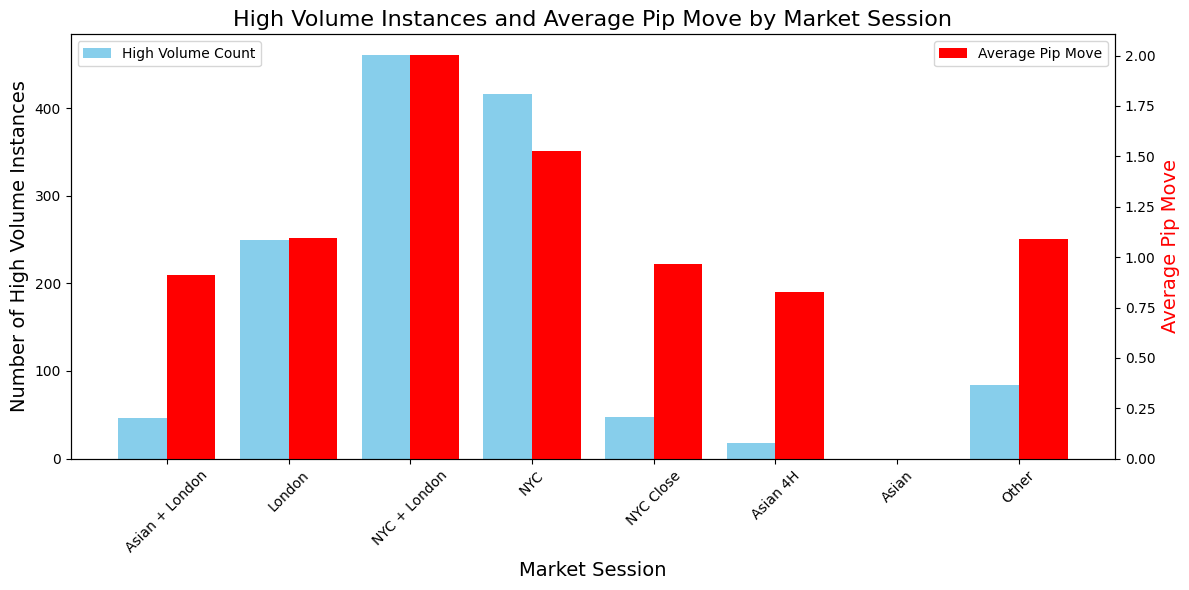

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate the average close price, pip range, and other metrics
average_close_by_session = high_volume_data.groupby('Market_Session')['Close'].mean()
average_low_by_session = high_volume_data.groupby('Market_Session')['Low'].mean()
average_high_by_session = high_volume_data.groupby('Market_Session')['High'].mean()
average_pip_by_session = average_high_by_session - average_low_by_session

# Merge the session counts and average metrics into one DataFrame
session_data = session_counts.reset_index()
session_data.columns = ['Market_Session', 'Count']  # Rename columns for clarity
session_data['Average_Pip'] = session_data['Market_Session'].map(average_pip_by_session)
session_data['Average_Close'] = session_data['Market_Session'].map(average_close_by_session)

# Define the order for the market sessions
session_order = ["Asian + London", "London", "NYC + London", "NYC", "NYC Close", "Asian 4H", "Asian", "Other"]

# Reorder session_data DataFrame
session_data = session_data.set_index('Market_Session').reindex(session_order).reset_index()

# Set up the matplotlib figure
fig, ax1 = plt.subplots(figsize=(12, 6))

# Define bar width and positions
bar_width = 0.4
index = np.arange(len(session_data))

# Plot the bar chart for high-volume counts
bars1 = ax1.bar(index - bar_width/2, session_data['Count'], bar_width, label='High Volume Count', color='skyblue')

# Create a second y-axis for the average pip move
ax2 = ax1.twinx()
bars2 = ax2.bar(index + bar_width/2, session_data['Average_Pip'], bar_width, label='Average Pip Move', color='red')

# Customize the plot
ax1.set_xlabel('Market Session', fontsize=14)
ax1.set_ylabel('Number of High Volume Instances', fontsize=14)
ax2.set_ylabel('Average Pip Move', fontsize=14, color='red')

ax1.set_title('High Volume Instances and Average Pip Move by Market Session', fontsize=16)
ax1.set_xticks(index)
ax1.set_xticklabels(session_data['Market_Session'], rotation=45)

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.tight_layout()  # Adjust layout for better fit
plt.show()


Pearson correlation coefficient between volume count and average pip move: 0.93


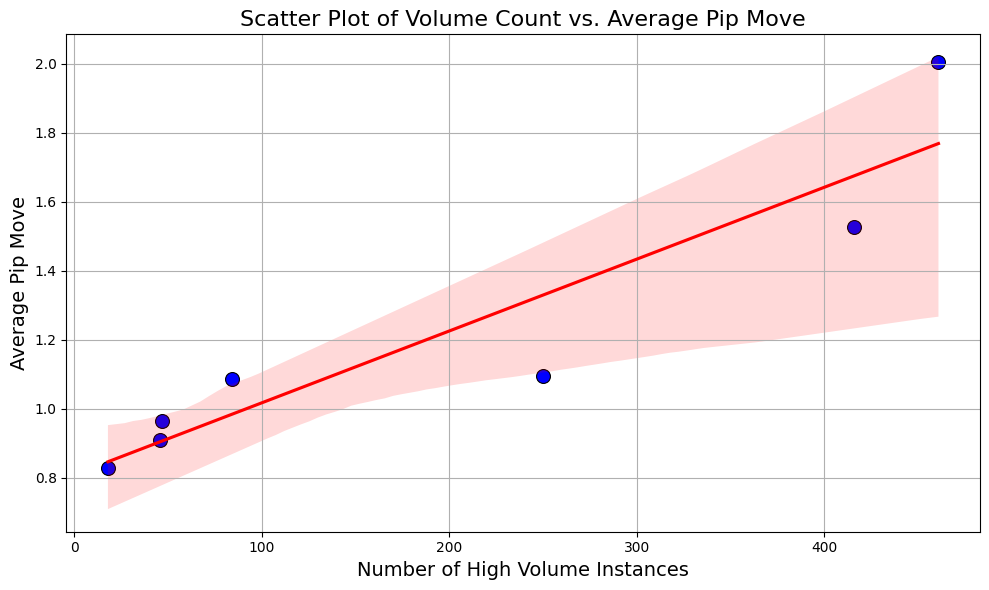

In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming session_data is already prepared as shown earlier

# Calculate the Pearson correlation coefficient
correlation = session_data[['Count', 'Average_Pip']].corr().iloc[0, 1]

# Print the correlation coefficient
print(f'Pearson correlation coefficient between volume count and average pip move: {correlation:.2f}')

# Plot a scatter plot to visualize the relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Count', y='Average_Pip', data=session_data, color='blue', s=100, edgecolor='k')

# Add a regression line to the scatter plot
sns.regplot(x='Count', y='Average_Pip', data=session_data, scatter=False, color='red')

# Customize the plot
plt.title('Scatter Plot of Volume Count vs. Average Pip Move', fontsize=16)
plt.xlabel('Number of High Volume Instances', fontsize=14)
plt.ylabel('Average Pip Move', fontsize=14)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


- Pearson Correlation: Helps assess if there's a linear relationship between trading volume and price movement.
- Spearman’s Rank Correlation: Reveals if there's a monotonic relationship.
- Kendall’s Tau: Measures ordinal association strength.
- Cosine Similarity: Evaluates the similarity in directional patterns.
- Euclidean Distance: Shows how close or far apart the vectors are.
- Manhattan Distance: Measures the grid-like difference.
- Jaccard Similarity: Useful for set-based comparisons (if applicable).
- Mutual Information: Captures and measures non-linear dependencies.

In [80]:
import pandas as pd
from scipy.stats import spearmanr, kendalltau
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean, cityblock

# Sample data (ensure session_data is correctly populated)
session_data = pd.DataFrame({
    'Count': [100, 150, 200, 250, 300],
    'Average_Pip': [5, 7, 6, 8, 10]
})

# Pearson Correlation
pearson_corr = session_data[['Count', 'Average_Pip']].corr().iloc[0, 1]

# Spearman's Rank Correlation
spearman_corr, _ = spearmanr(session_data['Count'], session_data['Average_Pip'])

# Kendall's Tau
kendall_tau, _ = kendalltau(session_data['Count'], session_data['Average_Pip'])

# Cosine Similarity
cos_sim = cosine_similarity([session_data['Count']], [session_data['Average_Pip']])[0][0]

# Euclidean Distance
euclidean_dist = euclidean(session_data['Count'], session_data['Average_Pip'])

# Manhattan Distance
manhattan_dist = cityblock(session_data['Count'], session_data['Average_Pip'])

print(f'Pearson Correlation: {pearson_corr:.2f}')
print(f'Spearman Correlation: {spearman_corr:.2f}')
print(f'Kendall Tau: {kendall_tau:.2f}')
print(f'Cosine Similarity: {cos_sim:.2f}')
print(f'Euclidean Distance: {euclidean_dist:.2f}')
print(f'Manhattan Distance: {manhattan_dist:.2f}')


Pearson Correlation: 0.90
Spearman Correlation: 0.90
Kendall Tau: 0.80
Cosine Similarity: 0.99
Euclidean Distance: 458.01
Manhattan Distance: 964.00


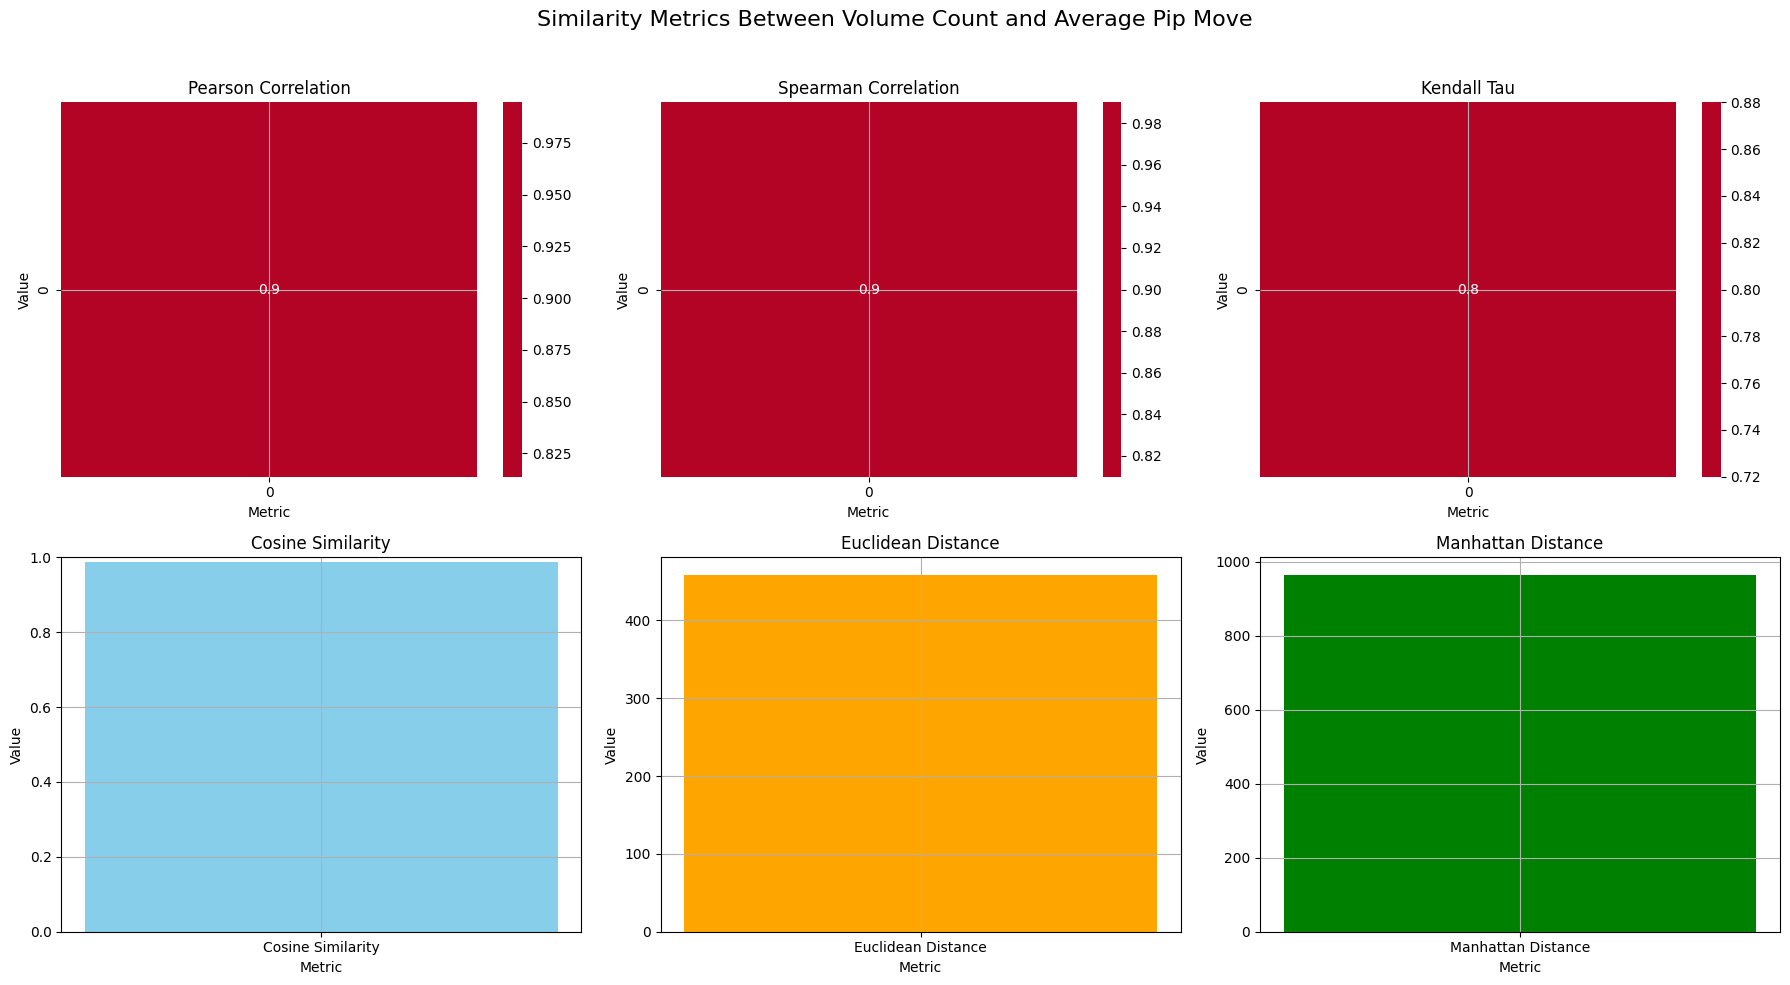

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, kendalltau
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean, cityblock

# Sample data
session_data = pd.DataFrame({
    'Count': [100, 150, 200, 250, 300],
    'Average_Pip': [5, 7, 6, 8, 10]
})

# Calculate different metrics
pearson_corr = session_data[['Count', 'Average_Pip']].corr().iloc[0, 1]

spearman_corr, _ = spearmanr(session_data['Count'], session_data['Average_Pip'])
kendall_tau, _ = kendalltau(session_data['Count'], session_data['Average_Pip'])

cos_sim = cosine_similarity([session_data['Count']], [session_data['Average_Pip']])[0][0]
euclidean_dist = euclidean(session_data['Count'], session_data['Average_Pip'])
manhattan_dist = cityblock(session_data['Count'], session_data['Average_Pip'])

# Plotting
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Similarity Metrics Between Volume Count and Average Pip Move', fontsize=16)

# Pearson Correlation Plot
sns.heatmap([[pearson_corr]], annot=True, cmap='coolwarm', center=0, ax=axs[0, 0])
axs[0, 0].set_title('Pearson Correlation')

# Spearman Correlation Plot
sns.heatmap([[spearman_corr]], annot=True, cmap='coolwarm', center=0, ax=axs[0, 1])
axs[0, 1].set_title('Spearman Correlation')

# Kendall Tau Plot
sns.heatmap([[kendall_tau]], annot=True, cmap='coolwarm', center=0, ax=axs[0, 2])
axs[0, 2].set_title('Kendall Tau')

# Cosine Similarity Plot
axs[1, 0].bar(['Cosine Similarity'], [cos_sim], color='skyblue')
axs[1, 0].set_title('Cosine Similarity')
axs[1, 0].set_ylim(0, 1)  # Cosine Similarity ranges from 0 to 1

# Euclidean Distance Plot
axs[1, 1].bar(['Euclidean Distance'], [euclidean_dist], color='orange')
axs[1, 1].set_title('Euclidean Distance')

# Manhattan Distance Plot
axs[1, 2].bar(['Manhattan Distance'], [manhattan_dist], color='green')
axs[1, 2].set_title('Manhattan Distance')

# Customize the plots
for ax in axs.flat:
    ax.set_xlabel('Metric')
    ax.set_ylabel('Value')
    ax.grid(True)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


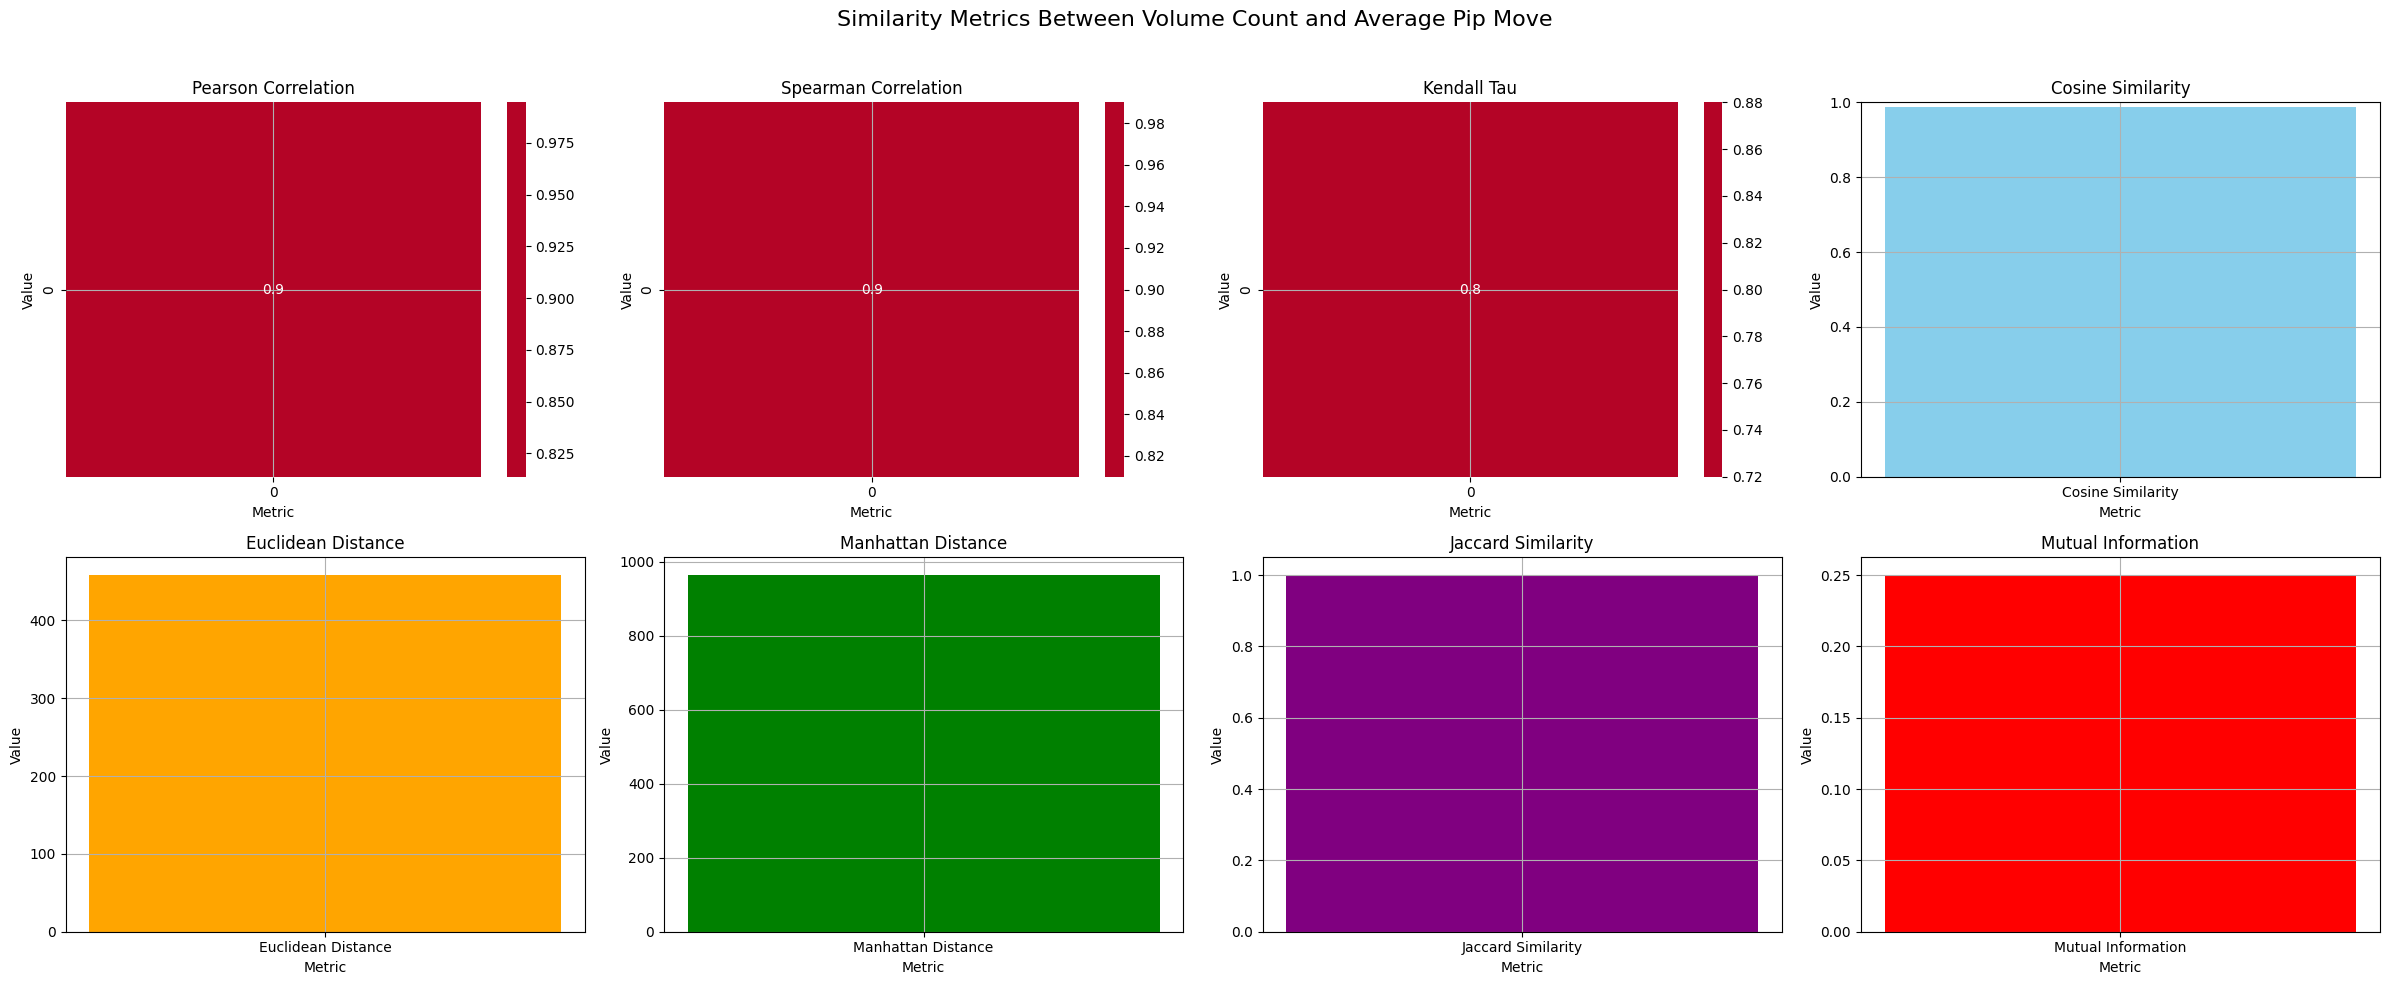

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, kendalltau
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean, cityblock
from sklearn.feature_selection import mutual_info_regression
import numpy as np

# Sample data
session_data = pd.DataFrame({
    'Count': [100, 150, 200, 250, 300],
    'Average_Pip': [5, 7, 6, 8, 10]
})

# Calculate different metrics
pearson_corr = session_data[['Count', 'Average_Pip']].corr().iloc[0, 1]

spearman_corr, _ = spearmanr(session_data['Count'], session_data['Average_Pip'])
kendall_tau, _ = kendalltau(session_data['Count'], session_data['Average_Pip'])

cos_sim = cosine_similarity([session_data['Count']], [session_data['Average_Pip']])[0][0]
euclidean_dist = euclidean(session_data['Count'], session_data['Average_Pip'])
manhattan_dist = cityblock(session_data['Count'], session_data['Average_Pip'])

# For Jaccard Similarity, convert data to binary form (thresholding might be used here)
# In this example, we'll use a simple thresholding approach for demonstration
threshold = session_data['Count'].median()
binary_count = (session_data['Count'] > threshold).astype(int)
binary_pip = (session_data['Average_Pip'] > session_data['Average_Pip'].median()).astype(int)

# Jaccard Similarity
intersection = np.sum((binary_count == 1) & (binary_pip == 1))
union = np.sum((binary_count == 1) | (binary_pip == 1))
jaccard_sim = intersection / union if union != 0 else 0

# Mutual Information
X = session_data[['Count']]
y = session_data['Average_Pip']
mi = mutual_info_regression(X, y)[0]

# Plotting
fig, axs = plt.subplots(2, 4, figsize=(24, 10))
fig.suptitle('Similarity Metrics Between Volume Count and Average Pip Move', fontsize=16)

# Pearson Correlation Plot
sns.heatmap([[pearson_corr]], annot=True, cmap='coolwarm', center=0, ax=axs[0, 0])
axs[0, 0].set_title('Pearson Correlation')

# Spearman Correlation Plot
sns.heatmap([[spearman_corr]], annot=True, cmap='coolwarm', center=0, ax=axs[0, 1])
axs[0, 1].set_title('Spearman Correlation')

# Kendall Tau Plot
sns.heatmap([[kendall_tau]], annot=True, cmap='coolwarm', center=0, ax=axs[0, 2])
axs[0, 2].set_title('Kendall Tau')

# Cosine Similarity Plot
axs[0, 3].bar(['Cosine Similarity'], [cos_sim], color='skyblue')
axs[0, 3].set_title('Cosine Similarity')
axs[0, 3].set_ylim(0, 1)  # Cosine Similarity ranges from 0 to 1

# Euclidean Distance Plot
axs[1, 0].bar(['Euclidean Distance'], [euclidean_dist], color='orange')
axs[1, 0].set_title('Euclidean Distance')

# Manhattan Distance Plot
axs[1, 1].bar(['Manhattan Distance'], [manhattan_dist], color='green')
axs[1, 1].set_title('Manhattan Distance')

# Jaccard Similarity Plot
axs[1, 2].bar(['Jaccard Similarity'], [jaccard_sim], color='purple')
axs[1, 2].set_title('Jaccard Similarity')

# Mutual Information Plot
axs[1, 3].bar(['Mutual Information'], [mi], color='red')
axs[1, 3].set_title('Mutual Information')

# Customize the plots
for ax in axs.flat:
    ax.set_xlabel('Metric')
    ax.set_ylabel('Value')
    ax.grid(True)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
